# Data Preprocessing

C:\Users\Bianchi\AppData\Local\Temp\ipykernel_19644\2132429994.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_apts['mobilia'] = df_apts['mobilia'].replace({'Sem mobília': 0, 'Mobiliado': 1})


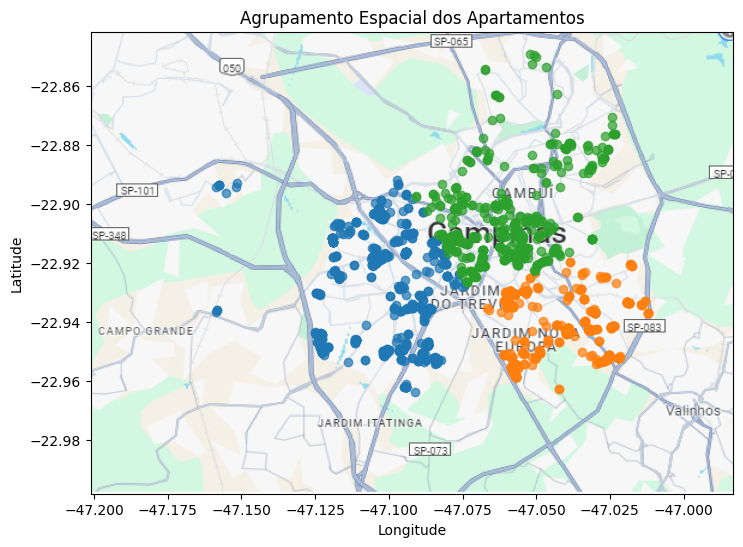

,link,valor,condominio,iptu,quartos,tamanho,vagas,banheiros,andar,mobilia,bairro,latitude,longitude,região
0,https://www.quintoandar.com.br/imovel/89444181...,389.0,450.0,62.0,2,86,2,2,5.5,0,jardim nova europa campinas,-22.935101,-47.059880,1
1,https://www.quintoandar.com.br/imovel/89376445...,395.0,380.0,101.0,2,110,2,3,5.5,0,jardim nova europa campinas,-22.932990,-47.060889,1
2,https://www.quintoandar.com.br/imovel/89351341...,315.0,500.0,50.0,2,82,1,2,9.5,0,jardim proenca campinas,-22.916321,-47.044068,2
3,https://www.quintoandar.com.br/imovel/89443433...,345.0,16.0,14.0,2,56,1,1,13.5,0,jardim nova europa campinas,-22.929722,-47.058948,1
4,https://www.quintoandar.com.br/imovel/89438885...,395.0,465.0,83.0,2,102,1,2,5.5,0,jardim nova europa campinas,-22.930571,-47.057067,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1752,https://www.quintoandar.com.br/imovel/89392551...,265.0,420.0,83.0,2,65,1,1,2.0,0,vila industrial campinas campinas,-22.912323,-47.077342,2
1753,https://www.quintoandar.com.br/imovel/89338793...,264.0,463.0,42.0,2,50,1,1,5.5,0,tres cruzes campinas,-22.952320,-47.021420,1
1754,https://www.quintoandar.com.br/imovel/89344213...,260.0,500.0,120.0,2,71,1,1,2.0,0,jardim chapadao campinas,-22.897394,-47.090663,2
1755,https://www.quintoandar.com.br/imovel/89402986...,245.0,320.0,13.0,2,45,1,1,2.0,0,vila carminha campinas,-22.936874,-47.030218,1


In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

df_apts = pd.read_csv('links_apartamentos.csv')
df_apts.dropna(inplace=True)
df_apts['valor'] = df_apts['valor'].astype(float)
df_apts['condominio'] = df_apts['condominio'].astype(float)
df_apts['quartos'] = df_apts['quartos'].astype(int)
df_apts['tamanho'] = df_apts['tamanho'].astype(int)
df_apts['vagas'] = df_apts['vagas'].astype(int)
df_apts['banheiros'] = df_apts['banheiros'].astype(int)

def extrair_iptu(iptu):
    match = re.search(r'R\$ (\d+(\.\d+)?)', str(iptu))
    if match:
        return float(match.group(1))
    else:
        return None
df_apts['iptu'] = df_apts['iptu'].apply(extrair_iptu)

def extrair_localizacao(localizacao):
    match = re.search(r'(\d+\.\d+,-?\d+\.\d+)', str(localizacao))
    if match:
        return "-" + match.group(1)
    else:
        return None
df_apts['localização'] = df_apts['localização'].apply(extrair_localizacao)

def extrair_andar_medio(andar):
    if '-' in andar: return 0
    elif 'Até' in andar:
        numero = re.search(r'Até (\d+)° andar', andar)
        return float(numero.group(1))/2 + 0.5
    elif 'a' in andar:
        numeros = re.search(r'(\d{1,2})° a (\d{1,2})°', andar)
        return (float(numeros.group(1))+float(numeros.group(2)))/2
df_apts['andar'] = df_apts['andar'].apply(extrair_andar_medio)

df_apts['mobilia'] = df_apts['mobilia'].replace({'Sem mobília': 0, 'Mobiliado': 1})
df_apts['bairro'] = df_apts['link'].str.split('quartos-').str[1].str.replace('-', ' ')

df_apts.dropna(inplace=True)


# Extrair as coordenadas de latitude e longitude da coluna 'localização'
df_apts[['latitude', 'longitude']] = df_apts['localização'].str.split(',', expand=True).astype(float)
df_apts.drop(columns=['localização'],inplace=True)

# Normalizar os dados, se necessário (opcional)

# Aplicar o algoritmo K-means
n_clusters = 3  # Escolha o número de clusters (grupos)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
df_apts['região'] = kmeans.fit_predict(df_apts[['latitude', 'longitude']])

# Plotar os grupos
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_data = df_apts[df_apts['região'] == cluster]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster}', alpha=0.7)
# Carregar a imagem da cidade de Campinas
img = mpimg.imread('campinas.png')

# Plotar a imagem
plt.imshow(img, extent=[-47.201200, -46.983075, -22.998374, -22.841634])

# Adicionar título e rótulos dos eixos
plt.title('Agrupamento Espacial dos Apartamentos')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrar o plot
plt.show()


df_apts

# Feature Selection

Common approaches for feature selection:
- Filter methods
    - Pearson correlation coefficient
    - Chi-square coefficient (Classification)
    - Mutual information
- Wrapper methods 
    - Forward Selection
    - Backward Elimination
    - Recursive feature elimination (RFE)
- Embedded methods
    - Regularization method (Lasso regression)

## Matriz de Correlação
O coeficiente de correlação de Pearson é uma medida estatística que avalia a relação linear entre duas variáveis contínuas

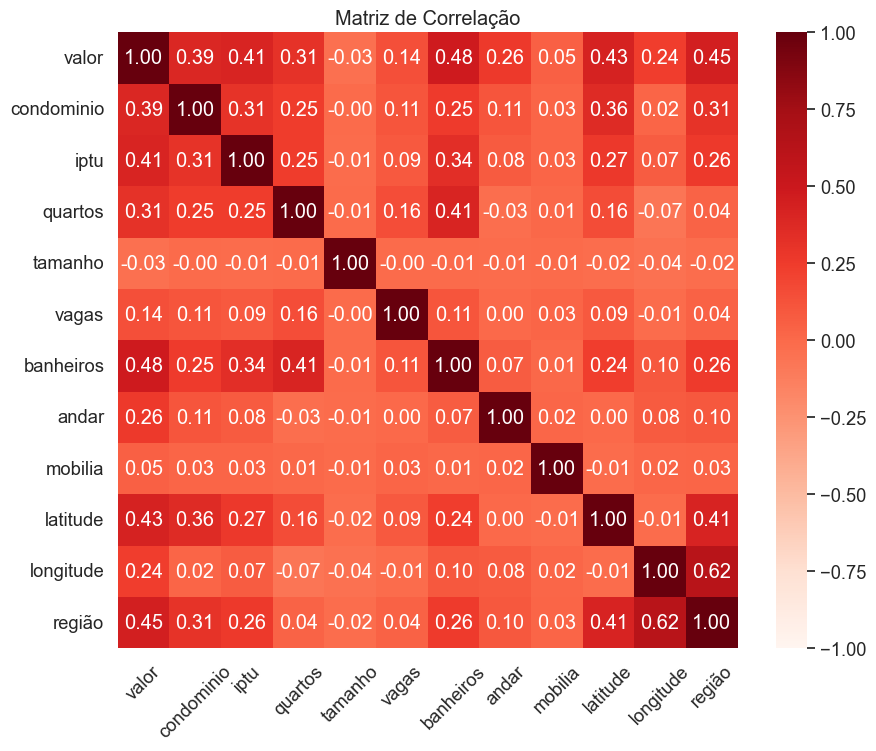

In [3]:
import pandas as pd
import seaborn as sns

df_apts_num = df_apts.drop(columns=['link','bairro'])

# Calcule a matriz de correlação de Pearson
correlation_matrix = df_apts_num.corr()
# Configure o estilo do heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(correlation_matrix, cmap='Reds', annot=True, fmt=".2f", vmin=-1, vmax=1)

# Adicione um título
plt.title('Matriz de Correlação')

# Rotacione os rótulos dos eixos x e y para melhor visualização
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Exiba o plot
plt.show()

As Features tamanho, mobilia e regiao (10 clusters) tiveram uma correlação baixa com o target value

A região com 3 clusters mostrou ser a divisão que possui a melor correlação com o valor

Latitude e Longitude possuem uma alta correlação com região (3 clusters), elas podem ser consideradas redundantes

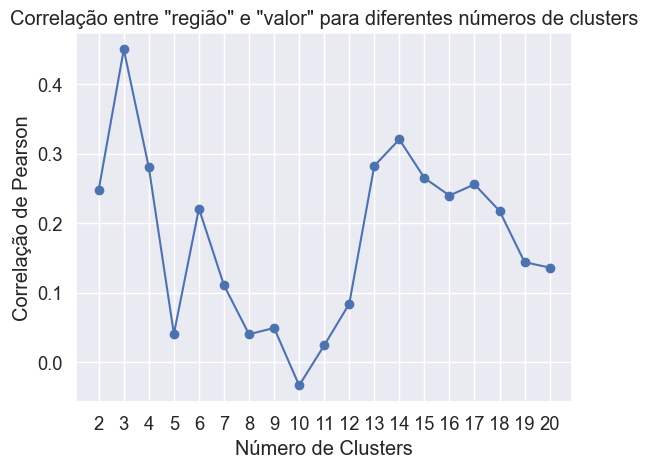

In [4]:
import numpy as np
import pandas as pd

# Definir numero de clusters a testar
ranges = range(2, 21)

correlation_values = []

# Para cada número de clusters, calcule o coeficiente de correlação de Pearson
for n_clusters in ranges:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    df_apts['região'] = kmeans.fit_predict(df_apts[['latitude', 'longitude']])
   
    # Calcule o coeficiente de correlação de Pearson entre 'região' e 'valor'
    correlation = df_apts['região'].corr(df_apts['valor'])
    correlation_values.append(correlation)

# Plotar os valores de correlação em função do número de clusters
plt.plot(ranges, correlation_values, marker='o')
plt.xticks(ranges)
plt.xlabel('Número de Clusters')
plt.ylabel('Correlação de Pearson')
plt.title('Correlação entre "região" e "valor" para diferentes números de clusters')
plt.grid(True)
plt.show()

## Mutual Information
A informação mútua é uma medida estatística que quantifica a dependência mútua entre duas variáveis. No contexto de seleção de features, a informação mútua pode ser usada para medir o quanto uma feature é informativa sobre a variável alvo.

In [5]:
from sklearn.feature_selection import mutual_info_regression

X = df_apts[['condominio','iptu','quartos', 'tamanho', 'vagas', 'banheiros', 'andar', 'mobilia','latitude','longitude','região']]
y = df_apts['valor']

# Calcule a informação mútua entre cada feature e a variável alvo
mi_scores = mutual_info_regression(X, y)

# Crie um DataFrame para visualização dos resultados
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})

# Ordene os resultados por ordem decrescente de informação mútua
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information', ascending=False)

mi_scores_df

,Feature,Mutual Information
10,região,0.321861
9,longitude,0.307998
8,latitude,0.269022
1,iptu,0.223587
0,condominio,0.179214
3,tamanho,0.169314
5,banheiros,0.132219
6,andar,0.046763
2,quartos,0.032098
4,vagas,0.006971


As features mobilia, vagas, quartos e andar mostraram ser pouco informativas para a definição do valor do imóvel

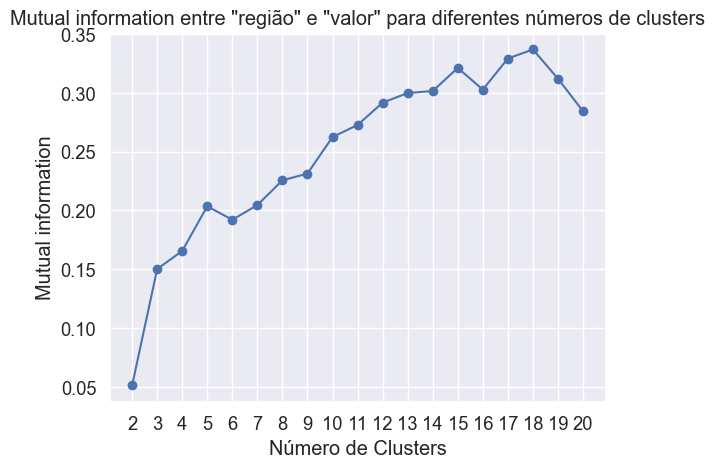

In [6]:
ranges = range(2, 21)

mutual_info_values = []

# Para cada número de clusters, calcule o Mutual Information
for n_clusters in ranges:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    df_apts['região'] = kmeans.fit_predict(df_apts[['latitude', 'longitude']])
    X = df_apts[['condominio','iptu','quartos', 'tamanho', 'vagas', 'banheiros', 'andar', 'mobilia','latitude','longitude','região']]
    y = df_apts['valor']

    # Calcule a informação mútua entre cada feature e a variável alvo
    mi_scores = mutual_info_regression(X, y)

    # Calcule o Mutual Information entre 'região' e 'valor'
    mutual_info = mi_scores[10]
    mutual_info_values.append(mutual_info)

# Plotar os valores de correlação em função do número de clusters
plt.plot(ranges, mutual_info_values, marker='o')
plt.xticks(ranges)
plt.xlabel('Número de Clusters')
plt.ylabel('Mutual information')
plt.title('Mutual information entre "região" e "valor" para diferentes números de clusters')
plt.grid(True)
plt.show()

O aumento no numero de clusters separando as regiões aumenta a informação da feature região. 

O numero de clusters 14 pode ser uma boa opção além do 3

## Forward Selection
O método de seleção de features Forward Selection é uma abordagem iterativa que começa sem features no modelo e adiciona uma a uma, escolhendo aquela que mais melhora o desempenho do modelo.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df_apts[['condominio','iptu','quartos', 'tamanho', 'vagas', 'banheiros', 'andar', 'mobilia','latitude','longitude','região']]
y = df_apts['valor']

# Inicialize um conjunto vazio de features selecionadas
selected_features = []

# Inicialize o modelo
model = LinearRegression()

# Número total de features
total_features = len(X.columns)

# Loop para selecionar as features
for i in range(total_features):
    best_feature = None
    best_performance = float('inf')
    
    # Para cada feature não selecionada
    for feature in X.columns:
        if feature not in selected_features:
            # Adicione temporariamente a feature ao conjunto de features selecionadas
            temp_selected_features = selected_features + [feature]
            
            # Treine o modelo usando apenas as features selecionadas temporariamente
            model.fit(X[temp_selected_features], y)
            
            # Avalie o desempenho do modelo
            y_pred = model.predict(X[temp_selected_features])
            performance = mean_squared_error(y, y_pred)
            print(performance)
            
            # Se o desempenho do modelo melhorar com a adição da nova feature
            if performance < best_performance:
                print(f'a feature {feature} melhorou o modelo')
                best_performance = performance
                best_feature = feature
            else: print(f'a feature {feature} não melhorou o modelo')
    # Adicione permanentemente a melhor feature ao conjunto de features selecionadas
    selected_features.append(best_feature)

# Resultado final das melhores features
print("Melhores features selecionadas:", selected_features)
print("Features não selecionadas:", [item for item in list(X.columns) if item not in selected_features])

3513.4087938363336
a feature condominio melhorou o modelo
3460.047930045973
a feature iptu melhorou o modelo
3742.6298971754973
a feature quartos não melhorou o modelo
4144.70368732232
a feature tamanho não melhorou o modelo
4066.083463529498
a feature vagas não melhorou o modelo
3186.7112935711148
a feature banheiros melhorou o modelo
3866.0644797496975
a feature andar não melhorou o modelo
4137.177508515063
a feature mobilia não melhorou o modelo
3394.9475784147044
a feature latitude não melhorou o modelo
3910.6193623235145
a feature longitude não melhorou o modelo
4072.203808004941
a feature região não melhorou o modelo
2865.147287276487
a feature condominio melhorou o modelo
2908.512199314263
a feature iptu não melhorou o modelo
3121.5546637557677
a feature quartos não melhorou o modelo
3182.950554910729
a feature tamanho não melhorou o modelo
3155.224473202553
a feature vagas não melhorou o modelo
2972.678607717305
a feature andar não melhorou o modelo
3177.0210612915653
a feature

O método Forward selection selecionou todas as features como úteis para o desempenho do modelo

Essa analise deve ser refeita posteriormente com um modelo melhor

## Regularização Lasso 
O método de regularização Lasso (Least Absolute Shrinkage and Selection Operator) é uma técnica de regressão linear que adiciona uma penalidade L1 à função de custo, forçando os coeficientes de algumas features a serem exatamente zero. Isso permite a seleção automática de features, tornando-as não influentes para o modelo.

In [8]:
from sklearn.linear_model import Lasso

X = df_apts[['condominio','iptu','quartos', 'tamanho', 'vagas', 'banheiros', 'andar', 'mobilia','latitude','longitude','região']]
y = df_apts['valor']

# Instancie o modelo Lasso com o parâmetro de regularização alpha
lasso_model = Lasso(alpha=0.1)  # Você pode ajustar o valor de alpha conforme necessário

# Treine o modelo usando os dados de treinamento
lasso_model.fit(X, y)

# Obtenha os coeficientes das features
coefficients = lasso_model.coef_

# Selecione as features com coeficientes não nulos como as melhores features
best_features = X.columns[coefficients != 0]

# Resultado final das melhores features
print("Melhores features selecionadas:", best_features)
print("Features não selecionadas:", [item for item in list(X.columns) if item not in best_features])

Melhores features selecionadas: Index(['condominio', 'iptu', 'quartos', 'tamanho', 'vagas', 'banheiros',
       'andar', 'mobilia', 'latitude', 'longitude', 'região'],
      dtype='object')
Features não selecionadas: []


O metodo Lasso Regression (alpha = 0.1) considerou apenas a feature longitude como não influente para o modelo

Essa analise deve ser refeita com um valor otimizado de alpha

Conclusão:

Nenhuma feature se destacou negativamente para ser retirada de cara do modelo.
Caso necessário, as features [mobilia, vagas, quartos, andar e tamanho] podem ser retiradas para possivel melhoria do modelo.
A feature região mostrou que pode ser útil para o modelo com divisões especificas de cluster (3 ou 14)

# Feature extraction

Approaches for feature extraction:

- Create new features
    - Ex: Feature cross, kernel-tricks...
- Dimensionality reduction techniques
    - Focus on reducing dimensionality by combining existing features into a smaller set of new features
    - Ex: Isomap, UMAP, PCA, Autoencoder, ...

# Feature scaling

Two common approaches
- min-max scaling (a.k.a. normalization)
    - Normalize data to the interval [0-1]
- standardization
    - Subtract the mean value and divide by the standard deviation

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Normalização
norm_scaler = MinMaxScaler()

# Padronização
standard_scaler = StandardScaler()

# Model Training and Evaluation

Os critérios de avaliação que serão utilizados para o modelo de regressão serão:
- Erro Absoluto Médio (MAE - Mean Absolute Error)
- Erro Quadrático Médio (MSE - Mean Squared Error)

Será usado o método k-fold cross-validation com 5 folds e um conjunto de teste composto por 10% do total, pois o modelo não deve ser muito complexo.

Caso o modelo aumente sua complexidade, é recomendado aumentar o conjunto de teste para até 30%.

In [10]:
from sklearn.model_selection import train_test_split

df_apts_num = df_apts.select_dtypes(include=['int', 'float'])

X = df_apts_num.drop(columns=['valor'])
y = df_apts['valor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

Hyperparameters tuning
- Grid search
- Random search
- Bayesian optimization

Gradient Descent Method: iterative optimization approach that gradually tweaks the model parameters  to minimize the cost function over the training set
- Batch Gradient Descent (BGD): At each iteration, uses all training samples to update θ
- Stochastic Gradient Descent (SGD): At each iteration, uses only one randomly selected sample to update θ
- Mini-Batch Gradient Descent (MBGD): At each iteration, uses a subset (mini-batch) of the training samples to update θ

## Linear Regression
- It is usually preferable to have at least a little bit of regularization: Avoid plain LR!
- Make sure you perform feature scaling if using Ridge/Lasso/Elastic Net regression
- Ridge is a good default, but if you suspect only a few features are actually useful, you should prefer Lasso or Elastic Net 
    - Both tend to reduce the useless features' weights down to zero.

Conclusão: 
- O modelo de regressão linear atingiu os melhores resultados utilizando alpha = 0.7 e normalização
    - MAE: 36.41968025317833
    - MSE: 2127.8780357709843

In [11]:
from sklearn.linear_model import Ridge
from skopt import BayesSearchCV
from skopt.space import Real

X_train_normalized = norm_scaler.fit_transform(X_train)
X_train_standard = standard_scaler.fit_transform(X_train)

# Defina o espaço de busca para o parâmetro alpha
param_space = {'alpha': Real(0.01, 1000, prior='log-uniform')}

# Inicialize o modelo Ridge
ridge = Ridge()

# Inicialize a pesquisa de hiperparâmetros com validação cruzada k-fold para X_train_normalized
opt_normalized = BayesSearchCV(ridge, param_space, cv=5, n_iter=50, random_state=0)
opt_normalized.fit(X_train_normalized, y_train)

# Inicialize a pesquisa de hiperparâmetros com validação cruzada k-fold para X_train_standard
opt_standard = BayesSearchCV(ridge, param_space, cv=5, n_iter=50, random_state=0)
opt_standard.fit(X_train_standard, y_train)

# Inicialize a pesquisa de hiperparâmetros com validação cruzada k-fold para X_train
opt_original= BayesSearchCV(ridge, param_space, cv=5, n_iter=50, random_state=0)
opt_original.fit(X_train, y_train)

# Extrair alphas e scores para X_train_normalized
alphas_normalized = []
scores_normalized = []
for result in opt_normalized.cv_results_['params']:
    alphas_normalized.append(result['alpha'])
    scores_normalized.append(opt_normalized.cv_results_['mean_test_score'][opt_normalized.cv_results_['params'].index(result)])

# Extrair alphas e scores para X_train_standard
alphas_standard = []
scores_standard = []
for result in opt_standard.cv_results_['params']:
    alphas_standard.append(result['alpha'])
    scores_standard.append(opt_standard.cv_results_['mean_test_score'][opt_standard.cv_results_['params'].index(result)])

# Extrair alphas e scores para X_train
alphas_original = []
scores_original = []
for result in opt_original.cv_results_['params']:
    alphas_original.append(result['alpha'])
    scores_original.append(opt_original.cv_results_['mean_test_score'][opt_original.cv_results_['params'].index(result)])


Melhores hiperparâmetros para X_train_normalized: OrderedDict({'alpha': 0.7041819471036634})
Melhor score de validação cruzada para X_train_normalized: 0.4814893289708369
Melhores hiperparâmetros para X_train_standard: OrderedDict({'alpha': 145.8808513519602})
Melhor score de validação cruzada para X_train_standard: 0.48047758674648805
Melhores hiperparâmetros para X_train: OrderedDict({'alpha': 0.01})
Melhor score de validação cruzada para X_train: 0.47806871626058367


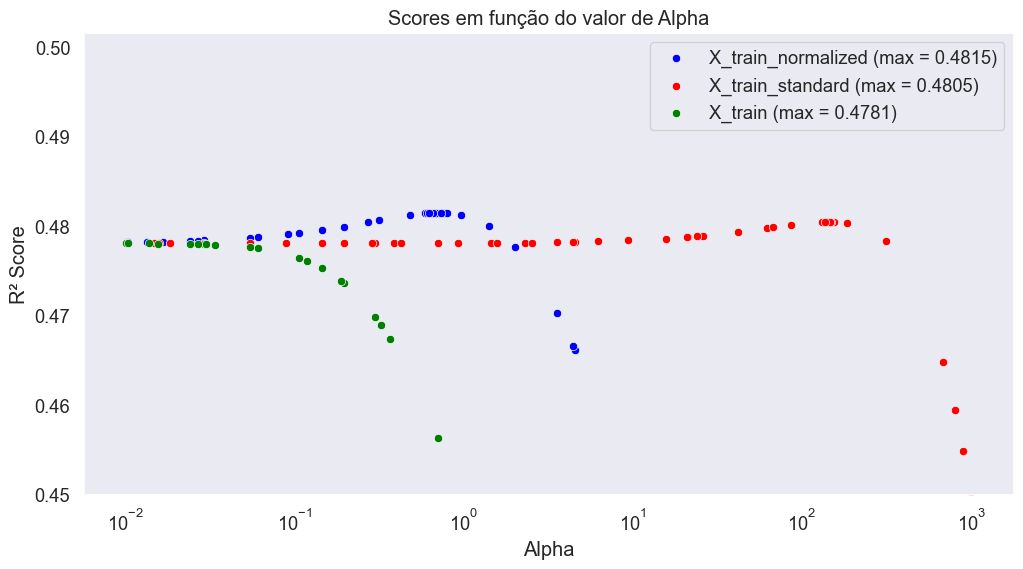

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melhores hiperparâmetros e melores scores encontrados
print("Melhores hiperparâmetros para X_train_normalized:", opt_normalized.best_params_)
print("Melhor score de validação cruzada para X_train_normalized:", opt_normalized.best_score_)
print("Melhores hiperparâmetros para X_train_standard:", opt_standard.best_params_)
print("Melhor score de validação cruzada para X_train_standard:", opt_standard.best_score_)
print("Melhores hiperparâmetros para X_train:", opt_original.best_params_)
print("Melhor score de validação cruzada para X_train:", opt_original.best_score_)

plt.figure(figsize=(12, 6))

# Plotar os scores para X_train_normalized
sns.scatterplot(x=alphas_normalized, y=scores_normalized, label=f'X_train_normalized (max = {max(scores_normalized):.4f})', color='blue')

# Plotar os scores para X_train_standard
sns.scatterplot(x=alphas_standard, y=scores_standard, label=f'X_train_standard (max = {max(scores_standard):.4f})', color='red')

# Plotar os scores para X_train
sns.scatterplot(x=alphas_original, y=scores_original, label=f'X_train (max = {max(scores_original):.4f})', color='green')

plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('Scores em função do valor de Alpha')
plt.xscale('log')
plt.ylim(bottom=0.45)
plt.grid()
plt.legend()
plt.show()

In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Inicialize o modelo Ridge com o valor de alpha específico
ridge_model = Ridge(alpha=0.70418)

# Função para realizar a validação cruzada e retornar a média dos scores
def cross_validate_metrics(model, X, y):
    scores_mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    scores_mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    return scores_mae.mean(), scores_mse.mean()

X_train_normalized = norm_scaler.fit_transform(X_train)

# Avalie o modelo usando diferentes conjuntos de dados
mae_train_norm, mse_train_norm = cross_validate_metrics(ridge_model, X_train_normalized, y_train)

print("Métricas do modelo Ridge com df_train_norm:")
print("MAE:", mae_train_norm)
print("MSE:", mse_train_norm)

Métricas do modelo Ridge com df_train_norm:
MAE: 36.41968025317833
MSE: 2127.8780357709843


## Decision Tree

Scikit-learn: max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes, max_features.

Conclusão:
- O modelo de Decision Tree atingiu os melhores resultados utilizando os parametros max_depth= 19, min_samples_leaf= 15, min_samples_split= 18
    - MAE: 35.349508175987395
    - MSE: 2106.3839146697087

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real

# Definir o espaço de busca para os hiperparâmetros
param_space = {'max_depth': (1, 50), 'min_samples_split': (2, 50), 'min_samples_leaf': (1, 50)}

# Inicializar o modelo de árvore de decisão
tree = DecisionTreeRegressor(random_state=0)

# Inicializar a pesquisa de hiperparâmetros com validação cruzada k-fold
opt = BayesSearchCV(tree, param_space, cv=5, n_iter=100, random_state=0)

# Executar a pesquisa de hiperparâmetros para X_train
opt.fit(X_train, y_train)

# Extrair os resultados da otimização
results = opt.cv_results_

# Imprimir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:")
print(opt.best_params_)

Melhores hiperparâmetros:
OrderedDict({'max_depth': 25, 'min_samples_leaf': 15, 'min_samples_split': 10})


Melhores hiperparâmetros:
OrderedDict({'max_depth': 27, 'min_samples_leaf': 15, 'min_samples_split': 25})
0.4856424243483288


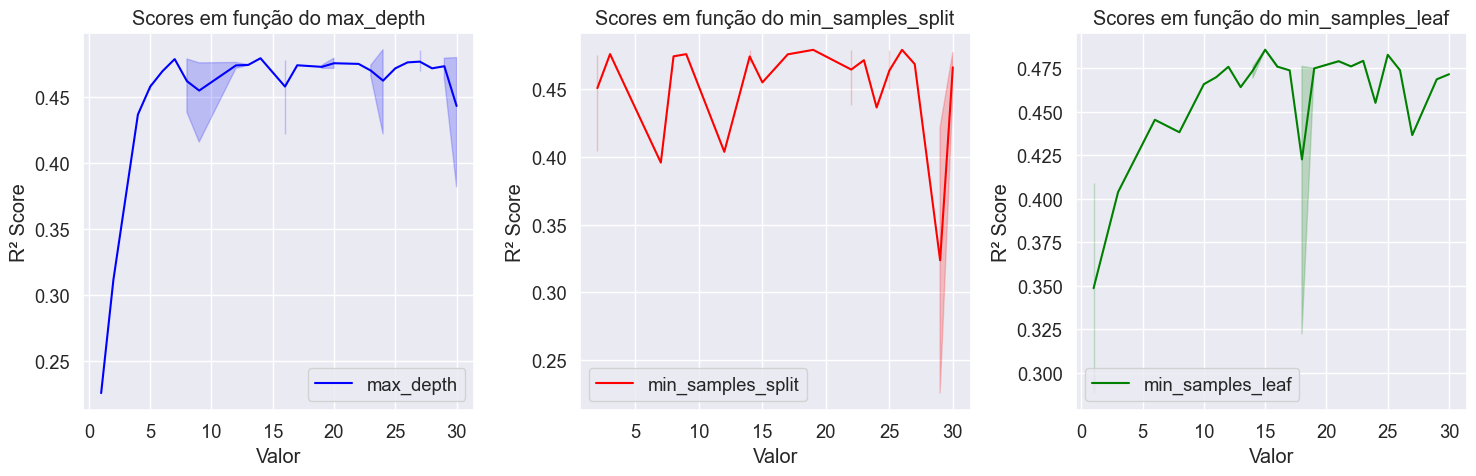

In [31]:
# Extrair alphas e scores para X_train_normalized
max_depth = []
min_samples_split = []
min_samples_leaf = []
scores = []
for result in opt.cv_results_['params']:
    max_depth.append(result['max_depth'])
    min_samples_split.append(result['min_samples_split'])
    min_samples_leaf.append(result['min_samples_leaf'])
    scores.append(opt.cv_results_['mean_test_score'][opt.cv_results_['params'].index(result)])

# Imprimir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:")
print(opt.best_params_)
print(opt.best_score_)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotar os scores para X_train_normalized
sns.lineplot(x=max_depth, y=scores, label='max_depth', color='blue', ax=axes[0])

# Configurações para o subplot 1
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Scores em função do max_depth')
axes[0].grid(True)
axes[0].legend()

# Plotar os scores para X_train_standard
sns.lineplot(x=min_samples_split, y=scores, label='min_samples_split', color='red', ax=axes[1])

# Configurações para o subplot 2
axes[1].set_xlabel('Valor')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Scores em função do min_samples_split')
axes[1].grid(True)
axes[1].legend()

# Plotar os scores para X_train
sns.lineplot(x=min_samples_leaf, y=scores, label='min_samples_leaf', color='green', ax=axes[2])

# Configurações para o subplot 3
axes[2].set_xlabel('Valor')
axes[2].set_ylabel('R² Score')
axes[2].set_title('Scores em função do min_samples_leaf')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

In [29]:
from sklearn.tree import DecisionTreeRegressor

# Inicializar o modelo Decision Tree
tree_model = DecisionTreeRegressor(max_depth= 19, min_samples_leaf= 15, min_samples_split= 18,random_state=0)

# Treinar o modelo
tree_model.fit(X_train, y_train)

# Avaliar o modelo
mae, mse = cross_validate_metrics(tree_model, X_train, y_train)

print("Métricas do modelo Decision Tree:")
print("MAE:", mae)
print("MSE:", mse)

Métricas do modelo Decision Tree:
MAE: 35.56403213490967
MSE: 2162.014565708024
